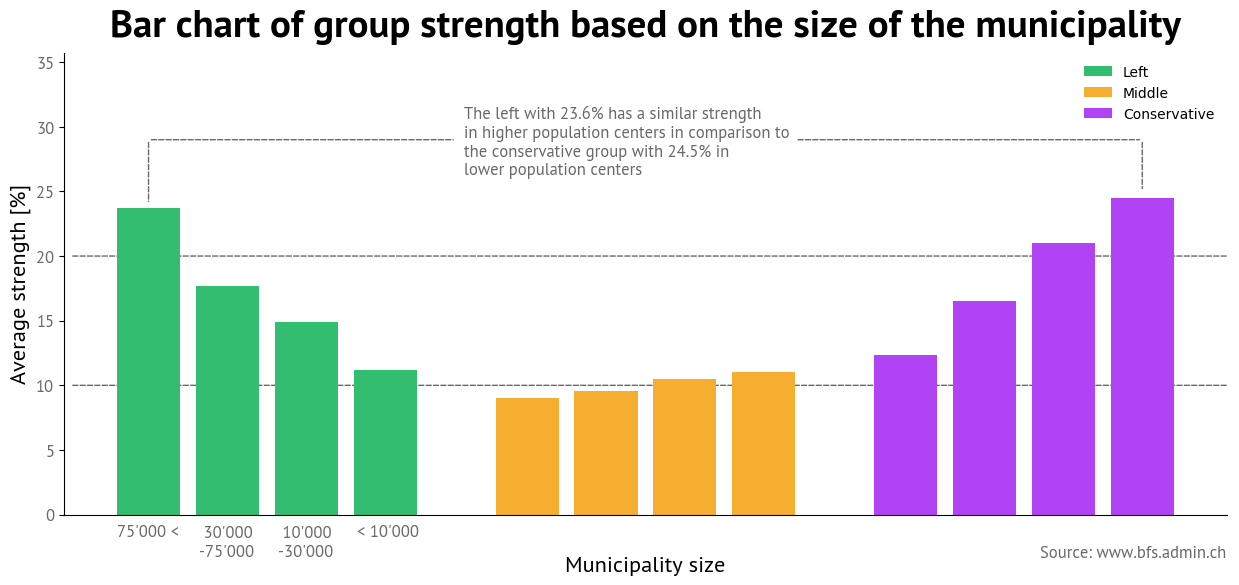

In [264]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from font_management import TITLE_FONT, SUBTITLE_FONT, DESCRIPTION_FONT, ANNOTATION_FONT

party_data = {
    '3': [[],[],[],[]],
    '13': [[],[],[],[]],
    '31': [[],[],[],[]],
    '1': [[],[],[],[]],
    '34': [[],[],[],[]],
    '4': [[],[],[],[]]
}

averaged_party_data_id = {
    '3': [],
    '13': [],
    '31': [],
    '1': [],
    '34': [],
    '4': []
}

averaged_party_data_names = {
    'SP': [],
    'GRÜNE': [],
    'GLP': [],
    'FDP': [],
    'Mitte': [],
    'SVP': []
}

    
    
def get_party_by_id(party_data, party_id):
    for party in party_data:
        if party.get('partei_id') == party_id:
            return party
    return None


def create_party_id_description_map(party_data):
    id_description_map = {}
    for party in party_data:
        short_description = next((desc['text'] for desc in party['partei_bezeichnung_kurz'] if desc['langKey'] == 'de'), 'Keine Beschreibung')
        id_description_map[party['partei_id']] = short_description

    return id_description_map


def extract_election_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    election_data_municipality_level = data.get('level_gemeinden', [])
    return election_data_municipality_level


def get_inhabitants_amount_voted(data_map, municipality_id, percentage):
    if municipality_id in data_map:
        inhabitants_in_municipality = data_map[municipality_id]
        percentage_voted = inhabitants_in_municipality * percentage
        return percentage_voted
    else:
        return None


def calculate_average_party_strength(election_data):
    party_strengths = defaultdict(list)

    for entry in election_data:
        party_id = entry.get('partei_id')
        party_strength = entry.get('partei_staerke')

        if party_id is not None and party_strength is not None:
            if isinstance(party_strength, str) and party_strength.endswith('%'):
                party_strength = float(party_strength.strip('%')) / 100
            elif isinstance(party_strength, str):
                party_strength = float(party_strength)

            party_strengths[party_id].append(party_strength)

    average_strengths = {party: sum(strengths) / len(strengths) for party, strengths in party_strengths.items()}
    return average_strengths


def fill_party_data():
    keys = party_data.keys()
    for entry in election_data_municipality_level:
        party_id = str(entry.get('partei_id'))
        party_strength = entry.get('partei_staerke')
        municipality_id = entry.get('gemeinde_nummer')
        inhabitants_in_municipality = inhabitants_map.get(str(municipality_id).zfill(4))
        if party_id in keys and inhabitants_in_municipality != None:
            if party_strength != None:
                if inhabitants_in_municipality > 75000:
                    party_data[party_id][0].append(party_strength)
                elif 30000 <= inhabitants_in_municipality <= 75000:
                    party_data[party_id][1].append(party_strength)
                elif 10000 <= inhabitants_in_municipality < 30000:
                    party_data[party_id][2].append(party_strength)
                else:
                    party_data[party_id][3].append(party_strength)

                    
def calculate_average(lst):
    if len(lst) > 0:
        return sum(lst) / len(lst)
    else:
        return None  

    
def average_out_party_data():
    for key in party_data:
        averaged_party_data_id[key].append(calculate_average(party_data[key][0]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][1]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][2]))
        averaged_party_data_id[key].append(calculate_average(party_data[key][3]))
    
    
def fill_averaged_party_data_names():
    for key in averaged_party_data_id:
        averaged_party_data_names[party_id_description_map.get(int(key))] = averaged_party_data_id[key]       
        
        
def average_party_pairs(data, pairs):
    averaged_pairs = {}
    for pair in pairs:
        
        averaged_list = []
        
        list1 = data[str(pair[0])]
        list2 = data[str(pair[1])]

        if len(list1) != len(list2):
            raise ValueError("Lists to be averaged must have the same length.")

        for i in range(len(list1)):
            averaged_list.append((list1[i] + list2[i]) / 2)

        averaged_pairs[f"{pair[0]}_{pair[1]}"] = averaged_list

    averaged_pairs["Left"] = averaged_pairs.pop("3_13")
    averaged_pairs["Middle"] = averaged_pairs.pop("31_34")
    averaged_pairs["Conservative"] = averaged_pairs.pop("1_4")
    
    return averaged_pairs
        
        
def create_bucket_bar_chart(party_data):
    # Create a bar chart with adjusted spacing
    fig, ax = plt.subplots(figsize=(15, 6))  
    keys = list(party_data.keys())

    # This will hold the positions of the bars on the x-axis, including the extra spaces
    adjusted_bar_positions = []

    # The width of each bar
    bar_width = 0.8
    # The space to leave empty after the 4th and 8th bars
    space_width = 0.8
    # Starting position for the first bar
    current_position = 0

    # Define colors for each political group
    colors = {'Left': '#33BD71', 'Middle': '#F5AE2F', 'Conservative': '#B243F5'}

    bar_counter = 0 
    bucket_categories = ["75'000 <", " 30'000\n-75'000", " 10'000\n-30'000", "< 10'000"]

    # Loop through each political group and their corresponding values
    for group_index, (key, values) in enumerate(party_data.items()):
        color = colors.get(key, 'gray')
        for value_index, value in enumerate(values):
            # Add a space before the 5th and 9th bars
            if value_index == 0 and group_index > 0:
                current_position += space_width
            # Record the position of this bar
            adjusted_bar_positions.append(current_position)
            # Plot the bar
            ax.bar(current_position, value, label=key if value_index == 0 else "", color=color, width=bar_width)
            # Annotate the first set of bars with the bucket categories
            if group_index == 0:
                if bar_counter == 0:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(-0.4, -2),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 1:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(0.64, -3.5),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 2:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(1.64, -3.5),  # Offset
                                **ANNOTATION_FONT)
                if bar_counter == 3:
                    ax.annotate(bucket_categories[value_index],
                                xy=(0, 0),
                                xytext=(2.64, -2),  # Offset
                                **ANNOTATION_FONT)
                bar_counter += 1
            # Move to the next position for the following bar
            current_position += 1
            
    # Adjust the y-axis limit as per user request
    ax.set_ylim(0, ax.get_ylim()[1] + 10)

    # Adding custom legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.legend(frameon=False)

    for label in ax.get_yticklabels():
        label.set_fontname(ANNOTATION_FONT['fontname'])
        label.set_fontsize(ANNOTATION_FONT['size'])
        label.set_color(ANNOTATION_FONT['color'])
        label.set_weight(ANNOTATION_FONT['weight'])

    
    # Set the chart title and labels
    ax.set_title("Bar chart of group strength based on the size of the municipality", **TITLE_FONT)
    ax.set_xlabel("Municipality size", **DESCRIPTION_FONT, labelpad=40)
    ax.set_ylabel("Average strength [%]", **DESCRIPTION_FONT)

    # Text annotation
    ax.annotate("",xy=(0,24),xytext=(0,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(3.9,29),xytext=(0,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
   
    ax.annotate("",xy=(12.6,29),xytext=(8.2,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(12.6,25),xytext=(12.6,29),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"})
    
    ax.annotate("",xy=(-1,20),xytext=(13.7,20),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"}, zorder=0.5)
    
    ax.annotate("",xy=(-1,10),xytext=(13.7,10),xycoords="data",
             arrowprops={"arrowstyle" : "-", "linestyle" : "--",
                         "linewidth" : 1, "color": "dimgray"}, zorder=0.5)
    
    ax.annotate("The left with 23.6% has a similar strength\nin higher population centers in comparison to\nthe conservative group with 24.5% in\nlower population centers", 
                xy=(0,0), xytext=(4, 26), 
                **ANNOTATION_FONT)

    
    fig.text(x=1, y=-0.1, s='Source: www.bfs.admin.ch', ha='right', va='bottom', transform=ax.transAxes, **ANNOTATION_FONT)
    
    plt.xticks([])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the chart with the new adjustments
    plt.show()




#------------
extracted_file_path = 'election_data/extracted_parties.json'
with open(extracted_file_path, 'r', encoding='utf-8') as file:
    extracted_parties_data = json.load(file)

party_id_description_map = create_party_id_description_map(extracted_parties_data)

file_path = 'election_data/dataset_elections_bfs_municipalities_only.json' 
election_data_municipality_level = extract_election_data(file_path)


file_path = 'election_data/inhabitants_2022_index_value.csv'

data_df = pd.read_csv(file_path, delimiter=':', header=None)

inhabitants_map = data_df.set_index(0)[1].to_dict()

average_strengths = calculate_average_party_strength(election_data_municipality_level)

parties = list(average_strengths.keys())
averages = list(average_strengths.values())
party_names = list()
for party in parties:
    party_names.append(party_id_description_map[party])
    
fill_party_data()

average_out_party_data()
fill_averaged_party_data_names()

pairs_to_average = [(3, 13), (31, 34), (1, 4)]

averaged_data_for_political_grouping = average_party_pairs(averaged_party_data_id, pairs_to_average)


create_bucket_bar_chart(averaged_data_for_political_grouping)

In [181]:
averaged_data_for_political_grouping

{'Left': [23.6898312550625,
  17.653020110264706,
  14.883526448613019,
  11.189848386099362],
 'Middle': [9.0339924449375,
  9.540862907058823,
  10.505289446415837,
  11.001662015641411],
 'Conservative': [12.375754451812501,
  16.556934436647058,
  20.972008932042442,
  24.51355202642739]}

In [ ]:
new_averaged_data

{'Left': [23.6898312550625,
  17.653020110264706,
  14.883526448613019,
  11.189848386099362],
 'Middle': [9.0339924449375,
  9.540862907058823,
  10.505289446415837,
  11.001662015641411],
 'Conservative': [12.375754451812501,
  16.556934436647058,
  20.972008932042442,
  24.51355202642739]}